<h1><center>LINMA2472 : Project 2 - part 2, Random Fourier Features </center></h1>

$\textbf{Author}$: Remi Delogne, remi.delogne@uclouvain.be

Import the following packages and functions. Refer to their documentation on the internet for more information on installation and usage.


In [1]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import accuracy_score

from keras.datasets import mnist #Contains the dataset
from matplotlib import pyplot

import time #Used to find the execution time of a part of the code

from IPython.display import display, HTML #For visual comfort
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# load dataset and rescale the data to [0,15]
''' load dataset: (we use the larger subset for testing and the smaller 
for training to demonstrate the efficiency of evaluating of new instances with RFF)'''
(testX,testy),(trainX,trainy) = mnist.load_data()
#Rescaling
trainX = np.floor(trainX/16)
testX = np.floor(testX/16)

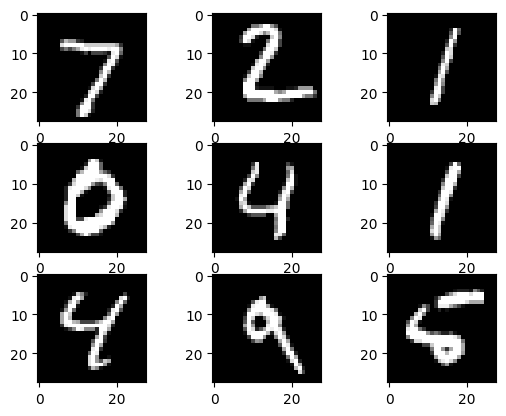

(10000, 784)


In [3]:
#Plot some images, for fun
for i in range(9):
    pyplot.subplot(330+1+i)
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

#Put the data in vector form
trainX=trainX.reshape((10000,-1))
testX=testX.reshape((60000,-1))
print(trainX.shape)

### Use the *time* package functions to time the executions of parts of your code:

In [4]:
#Example of timing a piece of code
tik=time.perf_counter() # Start
for i in range (10000000):
    i=i+1
tok=time.perf_counter() # Finish
print(f'Total time: {tok-tik:.4f} seconds')#prints the result to 3 decimal places

Total time: 1.0800 seconds


### Train a linear SVM on the training data and evaluate it on the testing data
Use the tik-tok method to see how long the classifier takes to evaluate the 60.000 testing instances.

Use the accuracy metric to judge the quality of your classifier.

In [ ]:
#Define the classifier
clfLin=svm.SVC(kernel="linear")

#Train the classifier
tik = time.perf_counter() # Start measuring training time
clfLin.fit(trainX,trainy)
tok = time.perf_counter() # Stop measuring training time
linear_training_time = tok - tik

#Evaluate its accuracy
tik = time.perf_counter()
predicted=clfLin.predict(testX)
score_linear=accuracy_score(testy,predicted)
tok = time.perf_counter()
linear_testing_time = tok - tik

print(f"Training finished in {linear_training_time:.3f} seconds,")
print(f"Testing Finished in {linear_testing_time:.3f} seconds with accuracy of {score_linear:.3f}.")

Training finished in 11.642 seconds,
Testing Finished in 94.569 seconds with accuracy of 0.907.


In [ ]:
# Training finished in 14.570 seconds,
# Testing Finished in 150.221 seconds with accuracy of 0.907.

### Train a Kernel SVM with the Gaussian Kernel on the training data and evaluate it on the testing data
Use the tik-tok method to see how long the classifier takes to evaluate the $60000$ testing instances.

Use the accuracy metric to judge the quality of your classifier.

You may stick to the default parameters of sci-kit learn.

In [ ]:
#Define the classifier
clfKernel=svm.SVC(kernel='rbf')
#Train it
tik = time.perf_counter()
clfKernel.fit(trainX, trainy)
tok = time.perf_counter()
rbf_training_time = tok - tik

#Use it
tik = time.perf_counter()
predicted=clfKernel.predict(testX)
score_rbf=accuracy_score(testy,predicted)
tok = time.perf_counter()
rbf_testing_time = tok - tik

print(f"Training finished in {rbf_training_time:.3f} seconds,")
print(f"Testing Finished in {rbf_testing_time:.3f} seconds with accuracy of {score_rbf:.3f}.")

Training finished in 21.783 seconds,
Testing Finished in 215.649 seconds with accuracy of 0.956.


In [ ]:
# Training finished in 33.737 seconds,
# Testing Finished in 331.451 seconds with accuracy of 0.956.

### *TO DO*: Use the following functions to implement Random Fourier Features

You are here going to try to approximate the Gaussian kernel used in the second classfier.

Use the first function to generate your $\boldsymbol\omega_i$ (using an appropriate distribution) and your $b_i$ (using appropriate distributions), this should return $D$ vectors $\boldsymbol\omega_i\in\mathbb R^d$ (in the form of a matrix for example) and $D$ values $b_i\in[0,2\pi]$. 

Use the second function to create the mapping $\boldsymbol z(\boldsymbol x)$ as described in the slides.

In [5]:

def generate_freq(D, d, std):
  W = np.random.normal(0,std,(D, d, 1))
  b = np.random.uniform(0, 2*np.pi, (D, 1)) 
  return W,b



def transform(data, W, b):
  D = len(b)
  return np.sqrt(2/D) * np.asarray([np.cos(  W[i].T@data.T + b[i]*np.ones(len(data)))[0] for i in range(D)]).T



### *TO DO*: Transform your trainX and testX

Use the function you defined to transform your data.

Make sure you only generate $\boldsymbol W$ and $\boldsymbol b$ once.

Use a standard deviation of $\frac{1}{100}$ et $D=300$ random features to start with. Watch out, in the original version of the homework it was specified that the variance was $\frac{1}{100}$ but it must be the standard deviation instead.

You may also use the tik-tok method to time the procedure of creating Random features.

In [6]:
D=300 #Number of sample vectors w_i
sigma=0.01 #std of distributon
d=28*28 #Original number of dimensions

tik = time.perf_counter()
W,b=generate_freq(D,d, sigma)
trainX_rff=transform(trainX, W, b)
testX_rff=transform(testX, W, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

RFF transformation time : 10.167 seconds.


In [40]:
#Sanity check, do the dimensions of your transformations match your expectation?
#Bear in mind that there are more instances in the test set than in the trianing set here
print(f"Dimension of trainX after transformation : {trainX_rff.shape}.")
print(f"Dimension of testX after transformation : {testX_rff.shape}.")


Dimension of trainX after transformation : (10000, 1).
Dimension of testX after transformation : (60000, 1).


### Use another linear SVM to classify the transformed data
Now that the instances have been transformed, theory tells us that they are much more ameneable to linear classification than before.

In [45]:
C=1
#Define the classifier
clfRff = svm.SVC(kernel="linear",C=C)

#Train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter() 
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#Use it
tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

Training Finished in 7.225 seconds
Testing Finished in 62.871 seconds with accuracy of 0.916


In [ ]:
# Training Finished in 7.225 seconds
# Testing Finished in 62.871 seconds with accuracy of 0.916

### Additional workspace 

Investigate the relationship between $D$ and the accuracy of the classifier.

In [10]:
#Define a vector to store the accuracy values you will get
accuracy=np.zeros(8)
time_array = np.zeros((8, 3))
#Define for which values of D you want to test the RFF
#maybe time some operations in the loop as well to see the RFF classifier becomes too slow as D grows
for i in (range(8)):
    D=[5, 10, 20, 50, 100, 200, 500, 1000][i]
    print("D is ", D)

    tik = time.perf_counter()
    W,b=generate_freq(D,d, sigma)
    trainX_rff=transform(trainX, W, b)
    testX_rff=transform(testX, W, b)
    tok = time.perf_counter() 
    training_time_rff = tok - tik
    print(f"creating RFF : {training_time_rff:.3f} seconds")
    time_array[i][0] = training_time_rff



    tik = time.perf_counter()
    clfRff = svm.SVC(kernel="linear")
    clfRff.fit(trainX_rff, trainy)
    tok = time.perf_counter() 
    training_time_rff = tok - tik
    print(f"traing time : {training_time_rff:.3f} seconds")
    time_array[i][1] = training_time_rff


    tik = time.perf_counter()
    predicted = clfRff.predict(testX_rff)
    tok = time.perf_counter() 
    training_time_rff = tok - tik
    print(f"{training_time_rff:.3f} seconds")
    time_array[i][2] = training_time_rff

    score_rff = accuracy_score(testy,predicted)
    accuracy[i] = score_rff

print(accuracy)
print(time_array)


# tik = time.perf_counter()
# tok = time.perf_counter() 
# training_time_rff = tok - tik
# print(f"{training_time_rff:.3f} seconds")

D is  5
creating RFF : 0.219 seconds
traing time : 4.739 seconds
22.252 seconds
D is  10
creating RFF : 0.275 seconds
traing time : 4.663 seconds
23.247 seconds
D is  20
creating RFF : 0.563 seconds
traing time : 2.957 seconds
24.378 seconds
D is  50
creating RFF : 1.387 seconds
traing time : 3.471 seconds
23.606 seconds
D is  100
creating RFF : 2.886 seconds
traing time : 3.197 seconds
26.041 seconds
D is  200
creating RFF : 5.711 seconds
traing time : 4.845 seconds
39.660 seconds
D is  500
creating RFF : 13.641 seconds
traing time : 10.653 seconds
79.307 seconds
D is  1000
creating RFF : 27.305 seconds
traing time : 15.664 seconds


In [1]:
import matplotlib.pyplot as plt
import numpy as np
# the accuracy of the linear SVM with RFF,

accuracy = [0.27373333, 0.38498333, 0.53865,  0.74556667, 0.84,  0.89896667, 0.93016667, 0.94343333]
timeMatrix = [
 [1.58435900e-01, 7.33797500e+00, 3.29611966e+01],
 [3.00891000e-01, 6.44995850e+00, 3.10691643e+01],
 [5.89777000e-01, 4.23899820e+00, 2.63975392e+01],
 [1.30077630e+00, 3.93779990e+00, 2.49074315e+01],
 [3.12639840e+00, 3.10104970e+00, 2.97078774e+01],
 [6.15553160e+00, 5.61012820e+00, 4.70750080e+01],
 [1.69245852e+01, 1.37226283e+01, 8.81485033e+01],
 [2.93837232e+01, 2.11920477e+01, 1.61495947e+02]]


x = [5, 10, 20, 50, 100, 200, 500, 1000]

### Don't forget to add plots and other nice things

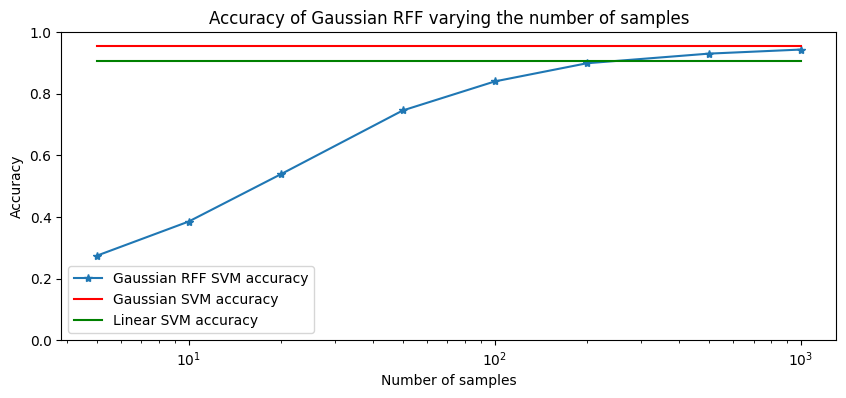

In [3]:


# the accuracy of the linear SVM with RFF,

plt.rcParams["figure.figsize"] = (10,4)
plt.plot( x, accuracy, '-*', label="Gaussian RFF SVM accuracy")
plt.plot(x, np.ones(8)*0.956, color = "red", label="Gaussian SVM accuracy")
plt.plot(x, np.ones(8)*0.907, color = "green", label="Linear SVM accuracy")

plt.xscale('log')
plt.ylim((0,1))
plt.title("Accuracy of Gaussian RFF varying the number of samples")
plt.ylabel("Accuracy")
plt.xlabel("Number of samples")
plt.legend()
plt.show()





In [ ]:
# •the time taken to create the RFF,


In [ ]:
# •the time taken to train the SVM with RFF,


In [ ]:
# •the time taken by the classifier to classify the testing instances

### Good luck =D